# 1. Setup

In [28]:
import matplotlib.pyplot as plt
import keras.optimizers as optimizers
from keras import regularizers
import tensorflow as tf
import math
import os

In [ ]:
# this jupyter notebook contains the code used to analyze the model chosen with the hyperparameters optimization

In [29]:
# image parameters
input_height = 69
input_width = 69

# augmentation parameters
rescale = True
if rescale:
    rescale_size=1./255
else:
    rescale_size=1
augmentation=False

rotation_range=40
width_shift_range=0.2
height_shift_range=0.1
shear_range=0.2
zoom_range=0.2
horizontal_flip=True
fill_mode='nearest'

In [ ]:
# best loss function for multi-class classification, measures the distance between two probability distributions
# the probability distribution of the output of the network and the true distribution of the labels
loss_function='categorical_crossentropy'

optimizer='rmsprop'
optimizer_learning_rate=1e-4
epochs=100
batch_size=32
num_classes = 9
regularizer=regularizers.l1_l2(l1=0.001, l2=0.001) # simultaneous l1 and l2, add 0.001*weight_coefficient_value + 0.001 * 1/2*weight^2

if optimizer == 'rmsprop':
    optimizer=optimizers.RMSprop(learning_rate=optimizer_learning_rate)

In [30]:
# customized metrics for multi class classification

import keras.backend as K
# best loss function for multi-class classification, measures the distance between two probability distributions
# the probability distribution of the output of the network and the true distribution of the labels
loss_function='categorical_crossentropy'

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

metrics = [
    precision,
    recall,
    tf.keras.metrics.CategoricalAccuracy(name='acc')
]

In [31]:
paths = {
    'TRAIN_PATH' : os.path.join('workspace', 'images', 'train'),
    'TEST_PATH' : os.path.join('workspace', 'images','test'),
    'EVAL_PATH' : os.path.join('workspace', 'images','eval'),
    'IMAGES_PATH': os.path.join('workspace','images','all'),
    'LOG_DIR' : os.path.join('models', 'log_dir')
 }

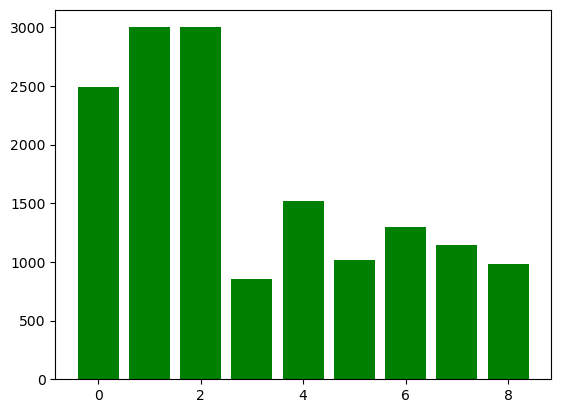

{0: 2488, 1: 3000, 2: 3000, 3: 858, 4: 1523, 5: 1016, 6: 1298, 7: 1146, 8: 981}


In [32]:
def plotTrainingDistribution():
    files_per_label = dict()
    for i in range(9):
      path = os.path.join(paths['TRAIN_PATH'],str(i))
      n_images = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
      files_per_label[i] = n_images
    plt.bar(list(files_per_label.keys()), files_per_label.values(), color='g')
    plt.show()
    print(files_per_label)
    return files_per_label

files_per_label = plotTrainingDistribution()

In [33]:
# class weights computation
num_classes = 9
tot_images = sum(list(files_per_label.values()))
weights = dict([ (class_label , tot_images/(num_classes * n_images)) for class_label, n_images in files_per_label.items()])
print(weights)

15310
{0: 0.6837263308324402, 1: 0.567037037037037, 2: 0.567037037037037, 3: 1.9826469826469826, 4: 1.1169475450499744, 5: 1.6743219597550307, 6: 1.3105632597158021, 7: 1.4843901493116152, 8: 1.7340582172386454}


In [34]:
# training set image data generator
from keras.preprocessing.image import ImageDataGenerator
if augmentation:
    train_datagen = ImageDataGenerator(
          rescale=rescale_size,
          rotation_range=rotation_range,
          width_shift_range=width_shift_range,
          height_shift_range=height_shift_range,
          shear_range=shear_range,
          zoom_range=zoom_range,
          horizontal_flip=horizontal_flip,
          fill_mode=fill_mode)
else:
    train_datagen = ImageDataGenerator(rescale=1./255)
    # to perform normalization we should never use information coming from the test set, only training set

train_dir=paths['TRAIN_PATH']
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(input_width, input_height), batch_size=batch_size, class_mode='categorical')

Found 15310 images belonging to 9 classes.


In [35]:
# validation set image data generator
val_datagen = ImageDataGenerator(rescale=rescale_size) # it should not be augmented

validation_dir=paths['EVAL_PATH']

validation_generator = val_datagen.flow_from_directory(validation_dir, target_size=(input_width, input_height), batch_size=batch_size, class_mode='categorical')

Found 3919 images belonging to 9 classes.


# 3. Model importation

In [53]:
model = tf.keras.models.load_model("./bayesian_optimization/tunedbayes_model.h", custom_objects = {"precision": precision, "recall": recall})

In [56]:
# load checkpoints
checkpoint_path = "./bayesian_optimization/trial_05/checkpoint"
model.load_weights(checkpoint_path)

In [58]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 65, 65, 128)       9728      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 33, 33, 128)      0         
 2D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 33, 33, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 29, 29, 64)        204864    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                      

In [63]:
# compile the model
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics)

# 4. Model training

In [64]:
n_images_eval = 0
for i in range(9):
    path = os.path.join(paths['EVAL_PATH'],str(i))
    #compute number of images in each eval folder and sum it up
    n_images_eval = n_images_eval + len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])

number_training = tot_images
number_eval = n_images_eval

3919


In [65]:
import keras

callbacks_list = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss', # should be part of the metrics specific during compilation
            patience=3,
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2, # divides LR by 5 when triggered
            patience=2 # called when stopped improving for 2 epochs
        ),
        keras.callbacks.TensorBoard(
            log_dir=paths['LOG_DIR'],
            write_graph=True,
            histogram_freq=1 # record activation histograms every 1 epoch
        ),
]

In [66]:
history = model.fit(
      train_generator,
      steps_per_epoch=int(math.ceil((1. * number_training) / batch_size)),
      epochs=150,
      class_weight=weights,
      validation_data=validation_generator,
      callbacks=callbacks_list,
      validation_steps=int(math.ceil((1. * number_eval) / batch_size)))

Epoch 1/150
479/479 [==============================] - 346s 716ms/step - loss: 0.4447 - precision: 0.8782 - recall: 0.8029 - acc: 0.7791 - val_loss: 0.6432 - val_precision: 0.8379 - val_recall: 0.8063 - val_acc: 0.8193 - lr: 1.0000e-04
Epoch 2/150
479/479 [==============================] - 406s 847ms/step - loss: 0.3969 - precision: 0.8898 - recall: 0.8221 - acc: 0.8557 - val_loss: 0.6411 - val_precision: 0.8378 - val_recall: 0.8002 - val_acc: 0.8176 - lr: 1.0000e-04
Epoch 3/150
479/479 [==============================] - 398s 830ms/step - loss: 0.3710 - precision: 0.8925 - recall: 0.8284 - acc: 0.8583 - val_loss: 0.6519 - val_precision: 0.8293 - val_recall: 0.7939 - val_acc: 0.8119 - lr: 1.0000e-04
Epoch 4/150
479/479 [==============================] - 383s 800ms/step - loss: 0.3705 - precision: 0.8911 - recall: 0.8289 - acc: 0.8591 - val_loss: 0.6732 - val_precision: 0.8306 - val_recall: 0.8021 - val_acc: 0.8160 - lr: 1.0000e-04
Epoch 5/150
479/479 [==============================] - 4

# 5. Visualization

In [67]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

In [ ]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation ACC')
plt.legend()
plt.figure()

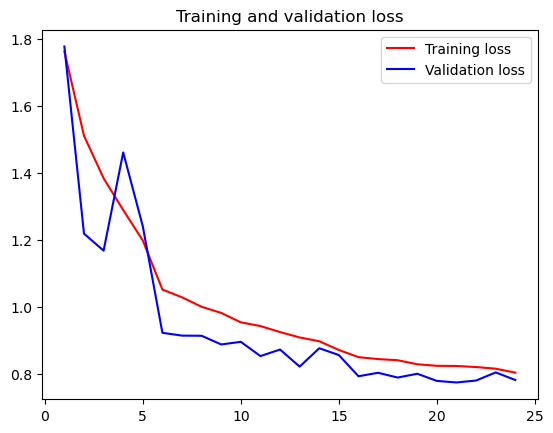

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

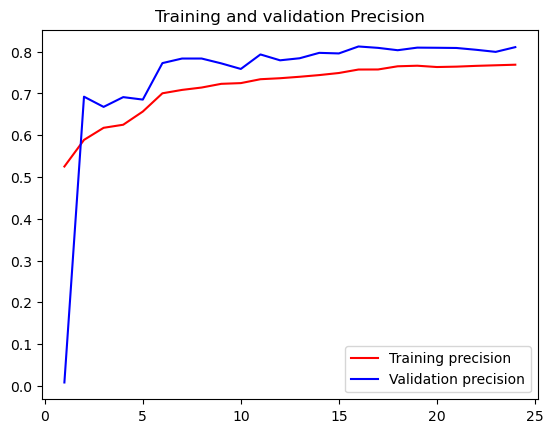

<Figure size 640x480 with 0 Axes>

In [ ]:
precision = history.history['precision']
val_precision = history.history['val_precision']
plt.plot(epochs, precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation Precision')
plt.legend()
plt.figure()

<Figure size 640x480 with 0 Axes>

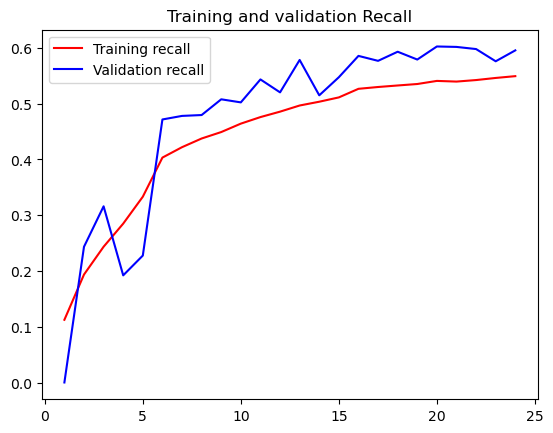

<Figure size 640x480 with 0 Axes>

In [ ]:
recall = history.history['recall']
val_recall = history.history['val_recall']
plt.plot(epochs, recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation Recall')
plt.legend()
plt.figure()

In [ ]:
# smooth curves if they look noisy
# replace each point with an exponential moving average of the previous points
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

In [ ]:
plt.plot(epochs,
         smooth_curve(acc), 'r', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.figure()

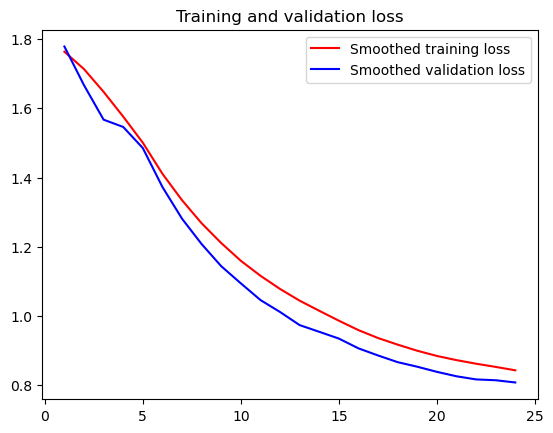

In [ ]:
plt.plot(epochs,
         smooth_curve(loss), 'r', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
# display average, the model may improve even if not reflected

# 6. Model testing

In [69]:
number_test = 0
for i in range(9):
      path = os.path.join(paths['TEST_PATH'],str(i))
      n_images = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
      number_test += n_images

In [70]:
test_dir=paths['TEST_PATH']
print(test_dir)
test_datagen = ImageDataGenerator(rescale=rescale_size) # it should not be augmented

test_generator = test_datagen.flow_from_directory(test_dir, target_size=(input_width, input_height), batch_size=batch_size, class_mode='categorical', classes=None, shuffle=False)

workspace/images/test
Found 2931 images belonging to 9 classes.


In [71]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

test_generator.reset()
Y_pred = model.predict_generator(test_generator, number_test // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['0','1','2','3','4','5','6','7','8']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

/var/folders/lp/fbpz2wyx1kb4b5zgt8w_tsp40000gn/T/ipykernel_34653/2558299678.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator, number_test // batch_size+1)


Confusion Matrix
[[298  51  43   1   7   0  23  21  27]
 [ 45 876  20   0   0   0   5   0   0]
 [ 62  34 725   2   2   0   9   1   0]
 [  0   0   1  38   8   2   0   0   0]
 [  2   0   4   3 191   6   0   0   1]
 [  0   0   0   2  13  63   0   0   1]
 [ 28   0   2   0   0   0 100  12   1]
 [ 24   0   0   0   0   0  20  74  11]
 [ 11   0   1   0   1   1   0  10  48]]
Classification Report
              precision    recall  f1-score   support

           0       0.63      0.63      0.63       471
           1       0.91      0.93      0.92       946
           2       0.91      0.87      0.89       835
           3       0.83      0.78      0.80        49
           4       0.86      0.92      0.89       207
           5       0.88      0.80      0.83        79
           6       0.64      0.70      0.67       143
           7       0.63      0.57      0.60       129
           8       0.54      0.67      0.60        72

    accuracy                           0.82      2931
   macro avg 

/var/folders/lp/fbpz2wyx1kb4b5zgt8w_tsp40000gn/T/ipykernel_34653/2081199222.py:20: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_generator, verbose = True)


92/92 [==============================] - 20s 216ms/step
Multiclass roc auc score: 0.8693246929586524


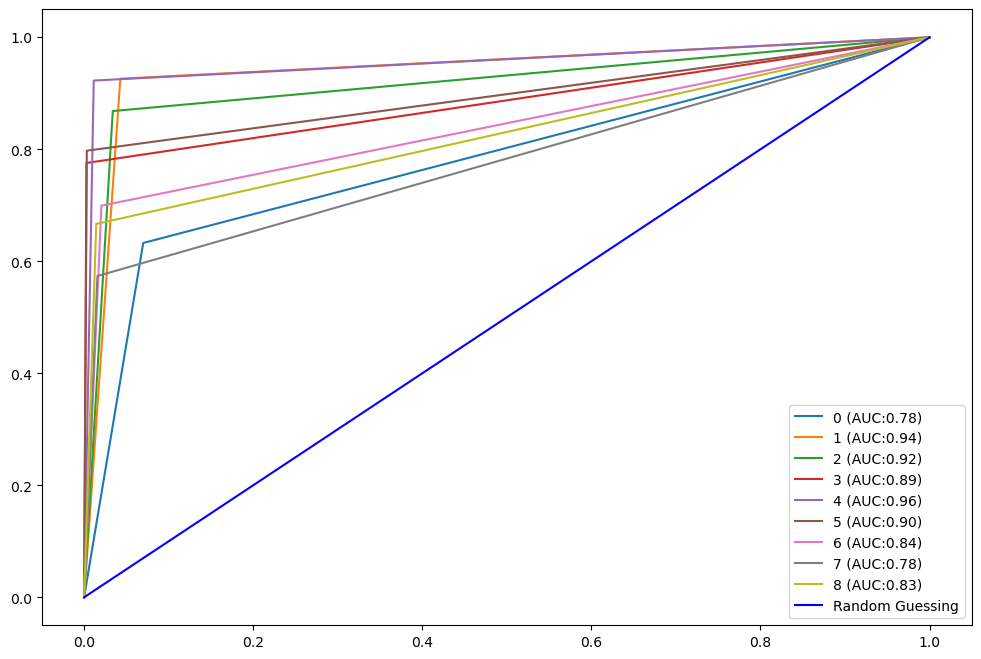

In [72]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, roc_auc_score, auc
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target_names):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    c_ax.legend()
    return roc_auc_score(y_test, y_pred, average=average)


test_generator.reset()
y_pred = model.predict_generator(test_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
print("Multiclass roc auc score:", multiclass_roc_auc_score(test_generator.classes, y_pred))

# 8. Model exportation

In [ ]:
model.save("models/hyperoptimized_model.h5")

# 9. Plot model as graph of layers

In [77]:
from keras.utils import plot_model

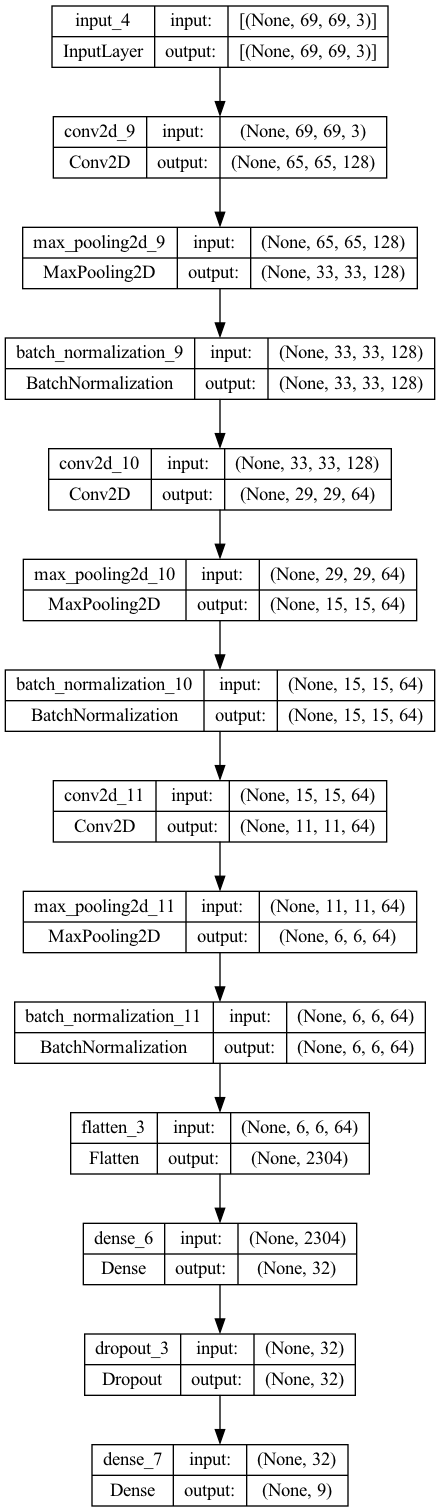

In [78]:
plot_model(model, show_shapes=True, to_file='model.png')